In [2]:
import pymysql as sql
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import os
import rds_config
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [3]:
# open database
sql.install_as_MySQLdb()
rds_host = rds_config.db_endpoint
name = rds_config.db_username
password = rds_config.db_password
db_name = rds_config.db_name

conn_str = "mysql+pymysql://{nm}:{pswrd}@{host}:3306/{dbnm}"\
    .format(nm=name, pswrd=password, host=rds_host, dbnm=db_name)
engine = create_engine(conn_str)

In [4]:
df_games = pd.read_sql('''SELECT GameID, Date, TeamID, Pace, Home
                                FROM TeamGameStats
                                WHERE Season = 2016 and GameTypeID = 1
                                ORDER BY GameID''', con=engine, parse_dates=['Date'])

df_games['Home'] = (df_games['Home'] == b'\x01')

df_games['AvgPace'] = df_games.groupby('TeamID')['Pace'].apply(pd.expanding_mean)
df_games['AvgPace'] = df_games.groupby('TeamID')['AvgPace'].shift(1)
df_games['AvgPaceLast5'] = df_games.groupby('TeamID')['Pace'].apply(lambda x: pd.rolling_mean(x, 5, 5))
df_games['AvgPaceLast5'] = df_games.groupby('TeamID')['AvgPaceLast5'].shift(1)
df_games['AvgPaceLast10'] = df_games.groupby('TeamID')['Pace'].apply(lambda x: pd.rolling_mean(x, 10, 10))
df_games['AvgPaceLast10'] = df_games.groupby('TeamID')['AvgPaceLast10'].shift(1)

df_games['RestDays'] = ((df_games['Date'] - df_games.groupby('TeamID')['Date'].shift(1)).apply(
    lambda x: x.astype('timedelta64[h]') / np.timedelta64(1, 'h')) / 24).round()

df_games.head()

,GameID,Date,TeamID,Pace,Home,AvgPace,AvgPaceLast5,AvgPaceLast10,RestDays
0,19283,2015-10-27 20:00:00,1,95.3,True,NaN,NaN,NaN,NaN
1,19283,2015-10-27 20:00:00,9,95.3,False,NaN,NaN,NaN,NaN
2,19284,2015-10-27 20:00:00,5,99.5,True,NaN,NaN,NaN,NaN
3,19284,2015-10-27 20:00:00,6,99.5,False,NaN,NaN,NaN,NaN
4,19285,2015-10-27 22:30:00,10,100.1,True,NaN,NaN,NaN,NaN


In [5]:
df_home = df_games[df_games['Home']]
df_away = df_games[~df_games['Home']]

df_games_new = df_home.merge(df_away, how='left', on='GameID')
df_games_new.dropna(inplace=True)

df_games_new.sort_values('GameID')
df_games_new.reset_index(drop=True, inplace=True)
df_games_new.drop('Pace_y', axis=1, inplace=True)
df_games_new.drop('Date_y', axis=1, inplace=True)
df_games_new.rename(columns={'Pace_x': 'GamePace'}, inplace=True)

df_games_new

,GameID,Date_x,TeamID_x,GamePace,Home_x,AvgPace_x,AvgPaceLast5_x,AvgPaceLast10_x,RestDays_x,TeamID_y,Home_y,AvgPace_y,AvgPaceLast5_y,AvgPaceLast10_y,RestDays_y
0,19433,2015-11-15 21:00:00,26,96.8,True,100.510000,99.38,100.51,2,28,False,94.550000,90.82,94.55,2
1,19436,2015-11-16 20:00:00,15,96.6,True,93.354545,92.80,93.12,1,21,False,98.410000,97.88,98.41,1
2,19437,2015-11-16 19:00:00,23,101.3,True,95.540000,96.66,95.54,2,7,False,97.830000,97.34,97.83,2
3,19440,2015-11-17 19:30:00,3,91.6,True,94.590000,96.14,94.59,3,1,False,96.100000,95.88,95.62,2
4,19441,2015-11-17 19:30:00,9,98.1,True,95.080000,95.50,95.08,2,6,False,93.540000,91.80,93.54,3
5,19442,2015-11-17 22:30:00,10,99.6,True,99.427273,96.72,99.36,3,28,False,94.754545,92.38,93.87,2
6,19444,2015-11-17 20:00:00,19,88.8,True,98.250000,95.02,98.25,2,8,False,96.890000,98.62,96.89,3
7,19445,2015-11-17 19:30:00,20,92.2,True,94.490909,92.88,94.42,2,4,False,95.110000,94.62,95.11,2
8,19447,2015-11-18 20:00:00,1,97.7,True,95.753846,94.26,95.01,1,26,False,100.172727,98.48,99.95,3
9,19448,2015-11-18 19:30:00,2,96.9,True,98.560000,95.28,98.56,2,7,False,98.145455,98.60,97.76,2


In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [7]:
df_team1_games = df_games[df_games['TeamID'] == 1]
df_not_team1_games = df_games[df_games['TeamID'] != 1]
df_team1_games_merged = df_team1_games.merge(df_not_team1_games, how='left', on='GameID')

df_team1_games_merged.dropna(inplace=True)
df_team1_games_merged.sort_values('GameID')
df_team1_games_merged.reset_index(drop=True, inplace=True)
df_team1_games_merged.drop('Pace_y', axis=1, inplace=True)
df_team1_games_merged.drop('Date_y', axis=1, inplace=True)
df_team1_games_merged.rename(columns={'Pace_x': 'GamePace'}, inplace=True)

msk = np.random.rand(len(df_team1_games_merged.index)) < 0.8
train_data = df_team1_games_merged[msk]
test_data = df_team1_games_merged[~msk]

train_data

,GameID,Date_x,TeamID_x,GamePace,Home_x,AvgPace_x,AvgPaceLast5_x,AvgPaceLast10_x,RestDays_x,TeamID_y,Home_y,AvgPace_y,AvgPaceLast5_y,AvgPaceLast10_y,RestDays_y
0,19440,2015-11-17 19:30:00,1,91.6,False,96.100000,95.88,95.62,2,3,True,94.590000,96.14,94.59,3
1,19447,2015-11-18 20:00:00,1,97.7,True,95.753846,94.26,95.01,1,26,False,100.172727,98.48,99.95,3
3,19491,2015-11-24 20:00:00,1,99.3,True,95.740000,93.20,95.21,3,2,False,98.184615,97.12,96.92,2
6,19525,2015-11-28 20:30:00,1,96.3,False,95.827778,96.02,95.14,1,27,True,93.968750,92.02,92.50,1
7,19536,2015-11-30 20:00:00,1,95.8,True,95.852632,95.74,94.81,2,21,False,97.552941,96.10,96.67,3
8,19550,2015-12-02 20:00:00,1,92.4,True,95.850000,96.18,94.69,2,28,False,93.661111,90.72,92.21,3
9,19565,2015-12-04 20:00:00,1,89.3,True,95.685714,94.80,94.50,2,14,False,96.527778,96.76,95.56,2
10,19603,2015-12-09 21:30:00,1,94.5,False,95.395455,93.54,94.55,5,7,True,96.413636,94.98,94.46,2
12,19626,2015-12-12 20:00:00,1,97.0,True,95.225000,92.84,94.29,2,27,False,93.520833,91.54,92.31,1
13,19639,2015-12-14 20:00:00,1,94.1,True,95.296000,93.08,94.63,2,16,False,92.963636,93.06,91.49,1


                            OLS Regression Results                            
Dep. Variable:               GamePace   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.218
Date:                Wed, 05 Apr 2017   Prob (F-statistic):              0.307
Time:                        17:35:23   Log-Likelihood:                -147.36
No. Observations:                  54   AIC:                             316.7
Df Residuals:                      43   BIC:                             338.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                13.14

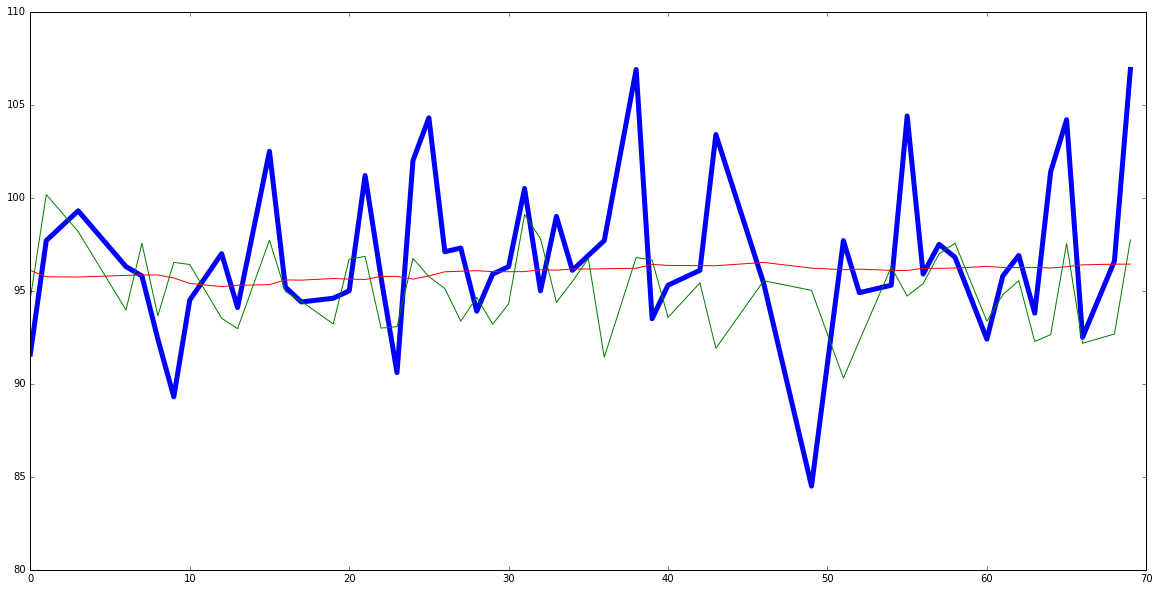

In [8]:
lm = smf.ols('GamePace ~ AvgPace_x + AvgPace_y + C(RestDays_x) + C(RestDays_y)', data=train_data).fit()# + RestDays_x + RestDays_y

print(lm.summary())
#fig, ax = plt.subplots(figsize=(15,20))
# fig = sm.graphics.plot_partregress_grid(lm, fig=fig)
plt.plot(train_data.index, train_data['GamePace'], 'b', linewidth='5')
plt.plot(train_data.index, train_data['AvgPace_x'], 'r')
plt.plot(train_data.index, train_data['AvgPace_y'], 'g')
#plt.plot(train_data.index, lm.fittedvalues, 'k', linewidth='5')

In [9]:
df_game_20175_players = pd.read_sql('''SELECT g.Player, p.*
                            FROM BasketballDatabase.PlayerGameStats p
                            JOIN BasketballDatabase.GeneralPlayerInfo g on g.PlayerID = p.PlayerID
                            WHERE GameID = 20175
                            ORDER BY TeamID, MP desc;''', con=engine)
df_game_20175 = pd.read_sql('SELECT * FROM BasketballDatabase.TeamGameStats WHERE GameID = 20175;',
                            con=engine, parse_dates=['Date'])

print(df_game_20175)
df_game_20175_players

   GameID  Season                Date  GameTypeID     Home Team  TeamID  \
0   20175    2016 2016-03-01 22:30:00           1  b'\x00'  ATL       1   
1   20175    2016 2016-03-01 22:30:00           1  b'\x01'  GSW      10   

   Q1Score  Q2Score  Q3Score  ...      FTr  ORBPercent  DRBPercent  \
0       26       22       22  ...    0.300        17.5        66.0   
1       32       27       16  ...    0.165        34.0        82.5   

   TRBPercent  ASTPercent  STLPercent  BLKPercent  TOVPercent   ORtg   DRtg  
0        45.2        67.6         9.1         7.5        15.8  106.7  110.8  
1        54.8        68.3        11.2         6.4         9.1  110.8  106.7  

[2 rows x 44 columns]


,Player,GameID,PlayerID,PlayerLink,TeamID,MP,FG,FGA,FGPercent,3P,...,ORBPercent,DRBPercent,TRBPercent,ASTPercent,STLPercent,BLKPercent,TOVPercent,USGPercent,ORtg,DRtg
0,Al Horford,20175,913,/players/h/horfoal01.html,1,41,8,16,0.500,1,...,3.2,19.1,12.3,14.1,1.3,0.0,20.0,23.5,88,111
1,Paul Millsap,20175,850,/players/m/millspa01.html,1,40,5,17,0.294,1,...,9.7,9.8,9.7,16.9,3.9,7.7,8.5,28.1,100,105
2,Kent Bazemore,20175,1288,/players/b/bazemke01.html,1,35,5,9,0.556,1,...,3.7,22.6,14.5,5.1,1.5,2.2,15.7,17.8,120,107
3,Kyle Korver,20175,594,/players/k/korveky01.html,1,33,4,9,0.444,3,...,7.9,14.8,11.8,5.1,4.8,0.0,0.0,13.1,128,105
4,Dennis Schroder,20175,1319,/players/s/schrode01.html,1,28,5,10,0.500,1,...,0.0,10.4,5.9,59.5,0.0,0.0,18.2,28.2,122,118
5,Jeff Teague,20175,1026,/players/t/teaguje01.html,1,24,3,6,0.500,1,...,0.0,4.1,2.4,43.2,0.0,0.0,33.3,18.3,98,122
6,Mike Scott,20175,1293,/players/s/scottmi01.html,1,20,4,6,0.667,3,...,0.0,4.8,2.7,0.0,2.6,0.0,0.0,14.2,161,115
7,Thabo Sefolosha,20175,821,/players/s/sefolth01.html,1,19,1,1,1.000,0,...,0.0,15.5,8.8,8.0,0.0,0.0,50.0,5.1,98,116
8,Tim Hardaway,20175,1335,/players/h/hardati02.html,1,17,2,5,0.400,1,...,0.0,5.7,3.3,0.0,0.0,0.0,14.5,19.4,83,121
9,Mike Muscala,20175,1376,/players/m/muscami01.html,1,2,0,1,0.000,0,...,0.0,42.6,24.3,0.0,0.0,0.0,50.0,41.9,0,101


In [10]:
GSW_2016_WS = pd.read_sql('''SELECT g.Player, g.PlayerID, WS 
                                        FROM BasketballDatabase.PlayerSeasonAdvStatsYTD a
                                        JOIN BasketballDatabase.GeneralPlayerInfo g on g.PlayerID = a.PlayerID
                                        WHERE Season = 2017 and TeamID = 10 and GameTypeID = 1
                                        ORDER BY WS desc;
                                        ''', con=engine)

GSW_Games_Players = pd.read_sql('''SELECT t.Season, t.Pace, p.*, a.WS, a.WSPer48
                                    FROM BasketballDatabase.PlayerGameStats p 
                                    JOIN BasketballDatabase.TeamGameStats t on t.GameID = p.GameID
                                    JOIN BasketballDatabase.PlayerSeasonAdvStats a on a.PlayerID = p.PlayerID
                                    WHERE p.TeamID = 10 and t.TeamID = 10 and t.Season = 2016 and t.GameTypeID = 1 and
                                          a.Season = 2016 and a.GameTypeID = 1''', con=engine)

GSW_Games = pd.read_sql('''SELECT * 
                            FROM BasketballDatabase.TeamGameStats 
                            WHERE Season = 2016 and GameTypeID = 1 and TeamID = 10''', con=engine)
NOT_GSW_Games = 

GSW_Games_Players['WSMins'] = GSW_Games_Players['WSPer48'] * GSW_Games_Players['MP']

#GSW_WS = pd.DataFrame(GSW_Games_Players.groupby('GameID')['WS'].sum()).reset_index()
GSW_WS = pd.DataFrame(GSW_Games_Players.groupby('GameID')['WSMins'].sum() / 
                      GSW_Games_Players.groupby('GameID')['MP'].sum(), columns=['WSMinsGMins']).reset_index()
GSW_Games = GSW_Games.merge(GSW_WS, how='left', on='GameID')
#print(GSW_Games)
GSW_Games['WS_norm'] = (GSW_Games['WSMinsGMins'] - GSW_Games['WSMinsGMins'].mean()) / (GSW_Games['WSMinsGMins'].max() - GSW_Games['WSMinsGMins'].min())
GSW_Games['PACE_norm'] = (GSW_Games['PACE'] - GSW_Games['PACE'].mean()) / (GSW_Games['PACE'].max() - GSW_Games['PACE'].min())

#df_norm = (df - df.mean()) / (df.max() - df.min())

plt.plot(GSW_Games.index, GSW_Games['WS_norm'], 'b', marker='o')
plt.plot(GSW_Games.index, GSW_Games['PACE_norm'], 'r', marker='o')

SyntaxError: invalid syntax (<ipython-input-10-290584bcec39>, line 18)